In [1]:
%load_ext autoreload
%autoreload 2
import flimview.flim as flim
import flimview.read_utils as ru
import flimview.models as models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook, tqdm
from matplotlib import cm

In [2]:
sdtfile = 'Psoriasis/test_dataset/FLIM_D/60_D_760nm_c11.sdt'

In [3]:
data,header = ru.read_sdt_file(sdtfile)

In [4]:
c11 = flim.FlimCube(data, header)

In [5]:
c11.show_header()

---------------------
sdt_info: *IDENTIFICATION
  ID        : SPC FCS Data File
  Title     : 60_D_760nm_c11
  Version   : 3  966 M
  Revision  : 8 bits ADC
  Date      : 2018-12-18
  Time      : 11:12:26
  Author    : System
  Company   : Unknown
  Contents  : Autosaved results for cycle 11 of 40 from FIFO_IMAGE measurement
*END


xpix: 256
ypix: 256
tpix: 256
tresolution: 48.86091184430619
---------------------------
Data Shape: (256, 256, 256)
Time resolution [ps]: 48.86091184430619
---------------------------


In [6]:
np.max(c11.data, axis=2).shape

(256, 256)

In [7]:
c11.mask_peak(5)

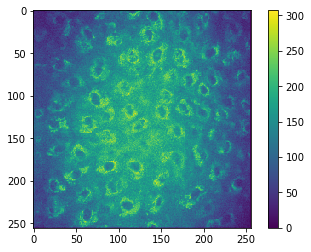

In [8]:
c11.unmask()
plt.imshow(c11.intensity)
plt.colorbar()

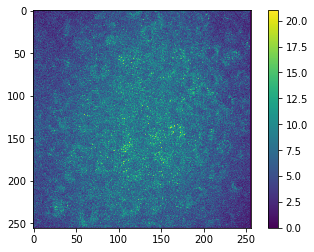

In [9]:
plt.imshow(c11.peak)
plt.colorbar()

In [10]:
c11_bin = flim.binCube(c11, bin=4, kernel='flat')

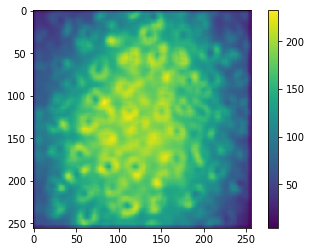

In [11]:
plt.imshow(c11_bin.intensity)
plt.colorbar()

In [12]:
np.sum(c11.data[:,:,20]),np.sum(c11_bin.data[:,:,20])

(6197, 6197.0)

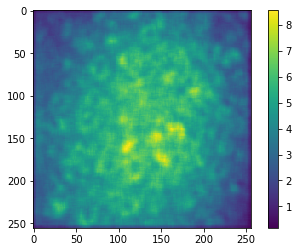

In [13]:
plt.imshow(c11_bin.peak)
plt.colorbar()

In [17]:
#c11.mask_peak(5)
#c11_bin.mask_peak(0, mask=c11.mask)
c11_bin.mask_intensity(110)

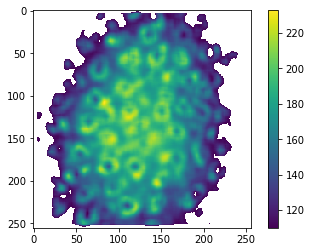

In [18]:
plt.imshow(c11_bin.intensity)
plt.colorbar()

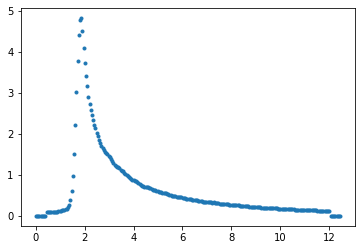

In [19]:
t,m = flim.meanDecay(c11_bin)
plt.plot(t,m, '.')

In [20]:
t1,m1,mmax,tshift = flim.cleanCurve(t,m, norm=True, threshold=0.02)

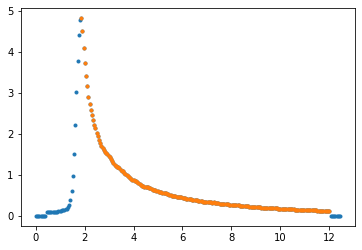

In [21]:
plt.plot(t,m, '.')
plt.plot(t1+tshift,m1*mmax,'.')

In [22]:
mymodel = models.model1
xf,yf, pfit, pcov, chi2 = flim.fitPixel(t,m, mymodel, initial_p=[0.8, 0.3, 3, 0.03], bounds=(0, np.inf), norm=True)

In [23]:
vd = flim.getModelVars(mymodel)

In [24]:
print(flim.printModel(mymodel, pfit, pcov, chi2, oneliner=False))

model1 (chi2 = 0.270): 
a1    = 0.595 ± 0.006
tau1  = 0.324 ± 0.007
tau2  = 2.431 ± 0.054
level = 0.019 ± 0.001


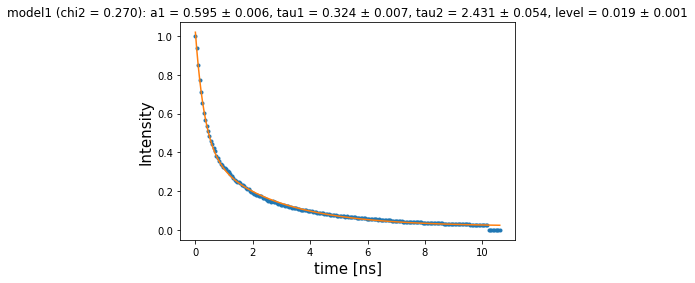

In [25]:
plt.plot(xf,yf,'.')
plt.plot(xf,mymodel(xf, *pfit))
plt.xlabel('time [ns]', fontsize=15)
plt.ylabel('Intensity', fontsize=15)
_=plt.title(flim.printModel(mymodel, pfit, pcov, chi2, oneliner=True))

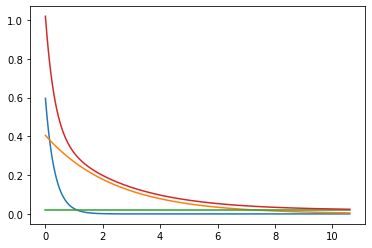

In [26]:
y1 = pfit[0]*np.exp(-xf/pfit[1])
y2 = (1-pfit[0])*np.exp(-xf/pfit[2])
y3 = np.zeros(len(xf))+ pfit[3]
plt.plot(xf, y1)

plt.plot(xf, y2)
plt.plot(xf, y3)
plt.plot(xf, y1+y2+y3)

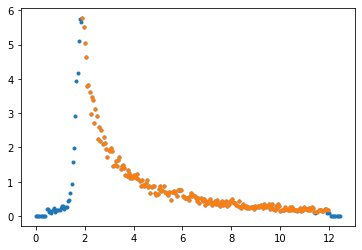

In [27]:
px = 130
py = 130
bounds0=[0.0, 0.0, 0. , 0.]
bounds1=[1, 1., 5., 1.]
y = c11_bin.data[px,py,:]
x = c11_bin.t
plt.plot(x,y,'.')
xx,yy,yyy,xxx=flim.cleanCurve(x,y,norm=True, threshold=0.02)
plt.plot(xx+xxx,yy*yyy,'.')

256 256


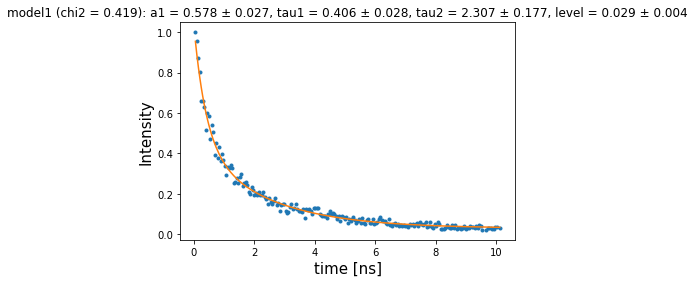

In [28]:
px = 130
py = 130
bounds0=[0.0, 0.0, 0. , 0.]
bounds1=[1, 1., 5., 1.]
y = c11_bin.data[px,py,:]
x = c11_bin.t
print(len(x), len(y))
xf,yf,pfit_i,pcov_i,chi2_i = flim.fitPixel(x,y, mymodel, initial_p=pfit, bounds= (bounds0, bounds1), norm=True, threshold=0.02, xshift=tshift) #bounds=(pfit-10*delta,pfit+10*delta))
plt.plot(xf,yf,'.')
plt.plot(xf,mymodel(xf, *pfit_i))
plt.xlabel('time [ns]', fontsize=15)
plt.ylabel('Intensity', fontsize=15)
_=plt.title(flim.printModel(mymodel, pfit_i, pcov_i, chi2_i, oneliner=True))
#plt.savefig('test.png')

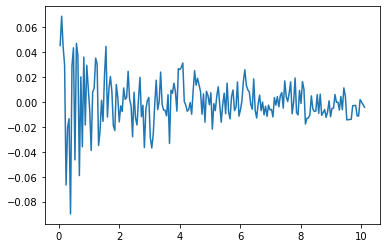

In [29]:
plt.plot(xf,(yf-mymodel(xf, *pfit_i)))

In [30]:
np.mean(yf-mymodel(xf, *pfit_i))

2.173460213548836e-13

In [31]:
c11_fit = flim.fitCube(c11_bin, mymodel, pfit,  bounds= (bounds0, bounds1), norm=True, threshold=0.02)

100%|██████████| 256/256 [04:42<00:00,  1.10s/it]


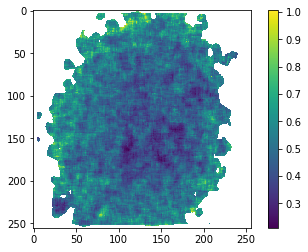

In [33]:
plt.imshow(c11_fit.chi2)
plt.colorbar()

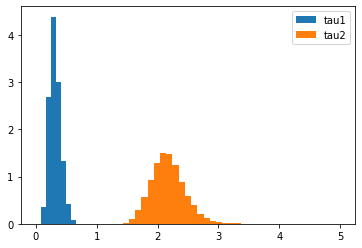

In [34]:
_=plt.hist(c11_fit.tau1.compressed(),bins=np.linspace(0,4,50), density=True, label='tau1')
_=plt.hist(c11_fit.tau2.compressed(),bins=np.linspace(0,5,50), density=True, label='tau2')
plt.legend(loc=0)

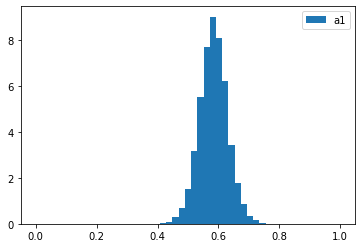

In [35]:
_=plt.hist(c11_fit.a1.compressed(),bins=np.linspace(0,1,50), density=True, label='a1')
plt.legend(loc=0)

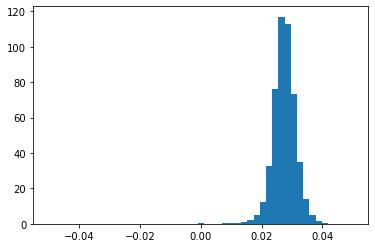

In [36]:
_=plt.hist(c11_fit.level.compressed(),bins=np.linspace(-.05,0.05,50), density=True)

### Compare

In [37]:
t1f = 'Psoriasis/Clinical_study/Data/2drepresentative_images_top/diseased/60_D_760nm_c11_t1.asc'
text_file = open(t1f, "r")
lines = text_file.read()
lines1 = lines.replace('\n',' ')
lines2 = lines1.split(' ')
del lines2[-1]
lines3 = [float(i) for i in lines2]
lines4 = np.reshape(lines3, (256, 256))
text_file.close()
t1data=lines4

In [38]:
t2f = 'Psoriasis/Clinical_study/Data/2drepresentative_images_top/diseased/60_D_760nm_c11_t2.asc'
text_file = open(t2f, "r")
lines = text_file.read()
lines1 = lines.replace('\n',' ')
lines2 = lines1.split(' ')
del lines2[-1]
lines3 = [float(i) for i in lines2]
lines4 = np.reshape(lines3, (256, 256))
text_file.close()
t2data=lines4

In [39]:
a1f = 'Psoriasis/Clinical_study/Data/2drepresentative_images_top/diseased/60_D_760nm_c11_a1.asc'
text_file = open(a1f, "r")
lines = text_file.read()
lines1 = lines.replace('\n',' ')
lines2 = lines1.split(' ')
del lines2[-1]
lines3 = [float(i) for i in lines2]
lines4 = np.reshape(lines3, (256, 256))
text_file.close()
a1data=lines4

In [40]:
a2f = 'Psoriasis/Clinical_study/Data/2drepresentative_images_top/diseased/60_D_760nm_c11_a2.asc'
text_file = open(a2f, "r")
lines = text_file.read()
lines1 = lines.replace('\n',' ')
lines2 = lines1.split(' ')
del lines2[-1]
lines3 = [float(i) for i in lines2]
lines4 = np.reshape(lines3, (256, 256))
text_file.close()
a2data=lines4

In [41]:
a1p = 'Psoriasis/Clinical_study/Data/2drepresentative_images_top/diseased/60_D_760nm_c11_a1p.asc'
text_file = open(a1p, "r")
lines = text_file.read()
lines1 = lines.replace('\n',' ')
lines2 = lines1.split(' ')
del lines2[-1]
lines3 = [float(i) for i in lines2]
lines4 = np.reshape(lines3, (256, 256))
text_file.close()
a1pdata=lines4

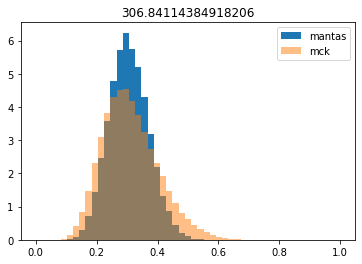

In [42]:
_=plt.hist(t1data.flatten()/1000.,bins=np.linspace(0,1,50), density=True,label='mantas')
#=plt.hist(t2data.flatten(),bins=np.linspace(0,3500,50), density=True)
_=plt.hist(c11_fit.tau1.compressed(),bins=np.linspace(0,1,50), density=True,alpha=0.5,label='mck')
#_=plt.hist(tau1m.flatten()*1000,bins=np.linspace(-1000,2000,50), density=True,alpha=0.5,label='mck_masked')
plt.legend(loc=0)
_=plt.title(np.mean(t1data.flatten()/1.))

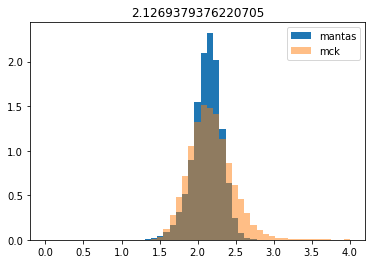

In [43]:
_=plt.hist(t2data.flatten()/1000.,bins=np.linspace(0,4,50), density=True, label='mantas')
#_=plt.hist(t2data.flatten(),bins=np.linspace(0,3500,50), density=True)
_=plt.hist(c11_fit.tau2.compressed(),bins=np.linspace(0,4,50), density=True,alpha=0.5, label='mck')
_=plt.title(np.mean(t2data.flatten()/1000.))
plt.legend(loc=0)

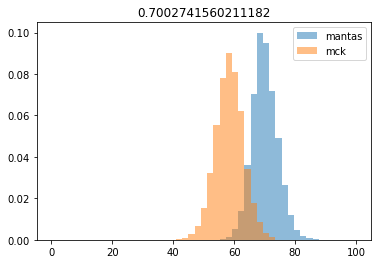

In [44]:
#_=plt.hist(a1[:,:,0].flatten(),bins=np.linspace(0.1,1000,50), density=True,alpha=0.5)
_=plt.hist(a1pdata.flatten(),bins=np.linspace(0.1,100,50), density=True,alpha=0.5, label='mantas')
_=plt.hist((c11_fit.a1.compressed())*100+0,bins=np.linspace(0.1,100,50), density=True,alpha=0.5, label='mck')
#_=plt.hist(level.compressed(),bins=np.linspace(0.1,2,50), density=True,alpha=0.5)
_=plt.title(np.mean(a1pdata.flatten()/100.))
plt.legend(loc=0)

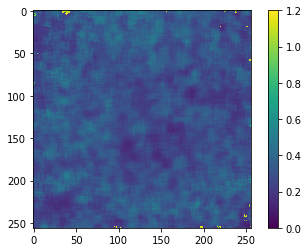

In [45]:
plt.imshow(t1data/1000.,vmin=0, vmax=1.2)
plt.colorbar()

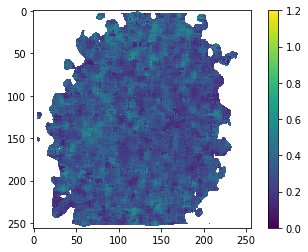

In [47]:
plt.imshow(c11_fit.tau1,vmin=0, vmax=1.2)
plt.colorbar()